# Microscopic Fungi Image Classification

Identifying similar microscopic structures is a considerably difficult challenge, especially for those who are not specialists, like doctors or microbiologists. Automating this function helps a lot when it comes to efficiency. This notebook implements a microscopic fungi image classification using ResNet101. The dataset, known as DeFungi, can be found on: https://www.kaggle.com/datasets/joebeachcapital/defungi.

## Dataset

DeFungi dataset consists of 9114 examples from five distinct fungi classes. The images are from superficial fungal infections caused by yeasts, molds, or dermatophyte fungi. All samples have been manually labeled and cropped with automated algorithms to produce the final dataset.


**Introductory Paper**
P456 Defungi: direct mycological examination of microscopic fungi images
By C. Sopo, Farshid Hajati, S. Gheisari. 2021
**Published in Medical Mycology**

## Setup and Dependencies

Troughout the implementation, some libraries will be used:

> NumPy is commonly used for numerical operations in Python, and it's often used for handling arrays and mathematical functions.

> PyTorch is a popular deep learning framework, and this import is necessary for building and training neural network models.

>The nn module provides classes and functions for building and training neural network models.

> These classes (DataLoader and random_split) are useful for handling datasets and creating data loaders for efficient batch processing during model training.

> These transformations are commonly used for preprocessing input and data augmentation before feeding it into a neural network.

> ImageFolder is a dataset class in PyTorch specifically designed for loading image datasets organized in folders.

> ResNet-101 is a popular convolutional neural network architecture, and pre-trained weights can be useful for transfer learning or feature extraction.

> Scikit-learn provides a variety of metrics for evaluating machine learning models.

> Matplotlib and Seaborn are widely used plotting libraries, and pyplot provides a simple interface for creating visualizations like graphs and charts.

> This is used for mounting Google Drive in the Colab environment, allowing you to access files stored in your Google Drive.

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split

from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torchvision.models import resnet101, ResNet101_Weights

from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


GPU makes our work significantly faster, it is always nice to use it when avaliable.

In [2]:
torch.manual_seed(9)
torch.cuda.manual_seed(9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Preprocessing

In any computer vision project, the quality and suitability of the dataset play a pivotal role in the performance of the model. This section displays steps of data preprocessing and exploration, where we analyze the dataset to ensure it aligns with the requirements of our computer vision task. Data preprocessing is a critical phase that involves cleaning, formatting, and transforming the raw data into a suitable format for model training.

In [3]:
dataset = ImageFolder('/content/drive/MyDrive/Introdução à Aprendizagem Profunda/CNN/Fungi Classification/data')
train_data, val_data = random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)-(int(len(dataset)*0.7)))])
len(train_data), len(val_data)

(6379, 2735)

Here is what our dataset originally looks like. It has 500x500 RGB images taken on several different occasions.

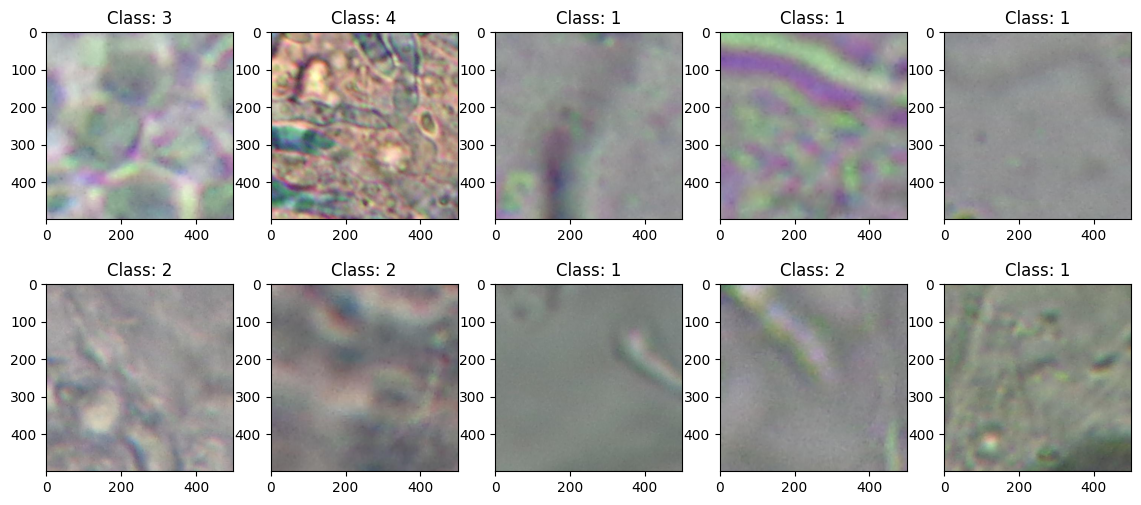

In [4]:
fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for i in range(10):
    ax[i//5, i%5].imshow(train_data[i][0])
    ax[i//5, i%5].set_title(f'Class: {train_data[i][1] + 1}')
    ax[i//5, i%5].axis('on')

plt.show()

Exploratory data analysis is an integral part of understanding the distribution and characteristics of the dataset. Through visualizations and statistical summaries, we aim to uncover insights that guide our modeling decisions. We can note, for example, that our dataset is very unbalanced, the first class consists of almost half the data.

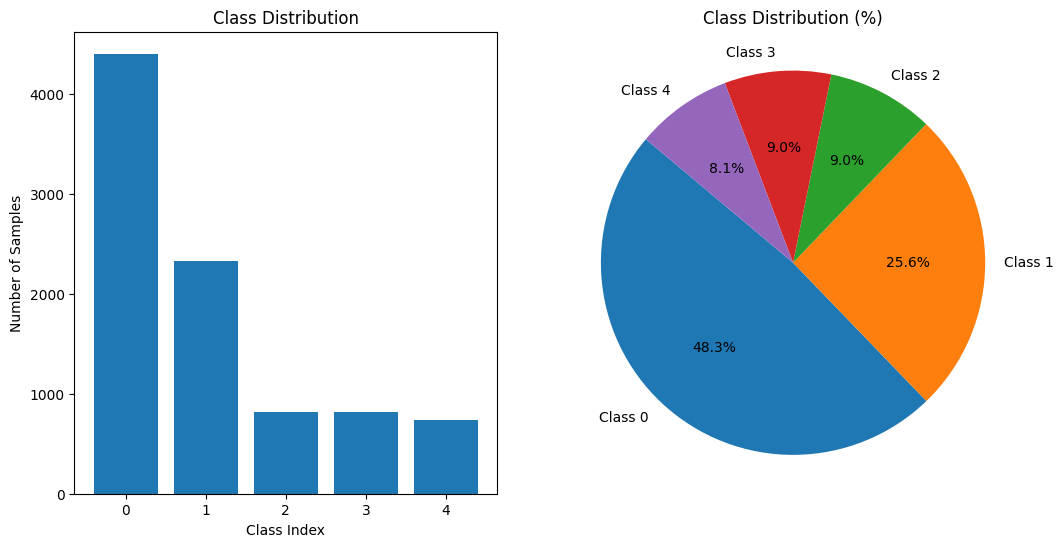

In [5]:
class_indices = torch.tensor(dataset.targets)
class_counts = torch.bincount(class_indices)
class_counts_dict = {class_idx: count.item() for class_idx, count in enumerate(class_counts) if count > 0}

total_samples = len(dataset)
class_percentages = {class_idx: count / total_samples * 100 for class_idx, count in class_counts_dict.items()}
labels = [f'Class {class_idx}' for class_idx in class_percentages.keys()]
sizes = list(class_percentages.values())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(class_counts_dict.keys(), class_counts_dict.values())
ax1.set_xlabel('Class Index')
ax1.set_ylabel('Number of Samples')
ax1.set_title('Class Distribution')
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Class Distribution (%)')

plt.show()

In order to improve our performance, it is advised to perform some transformations in our dataset. Network architectures that were trained for ImageNet competition, such as ResNet, perform better with 224x224 images (like ImageNet's images). Therefore, resizing our samples may help.

We also defined some other random transformations, such as flips and color variations. These make our model more robust and general.

Finally, as PyTorch works with tensors, we need to change our data types.

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


train_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = MyDataset(train_data, train_transforms)
val_dataset = MyDataset(val_data, data_transforms)

In [7]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Here is what our dataset looks like after those transformations. Notice the difference in size and some slight color variations.

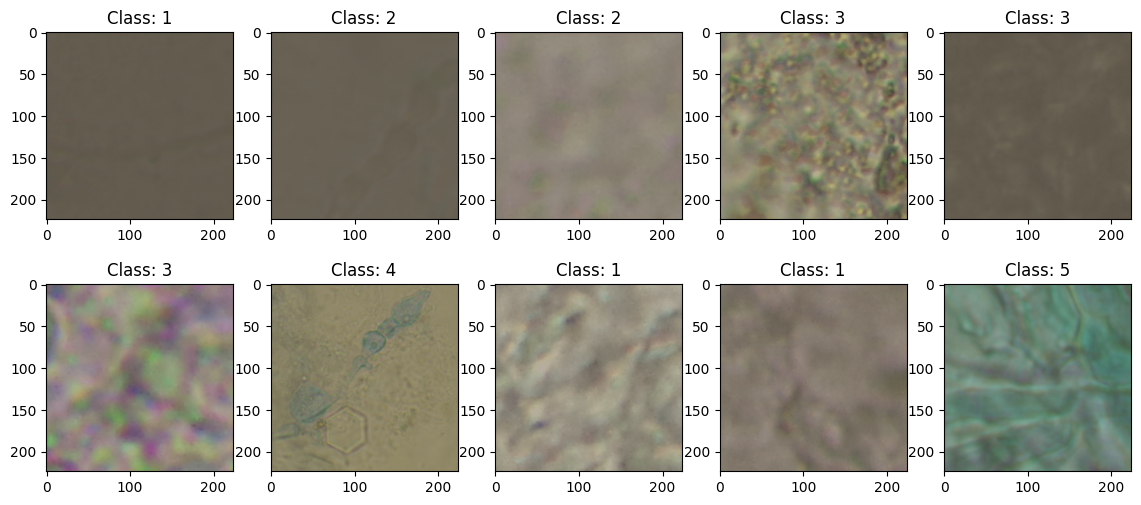

In [8]:
unnormalize = v2.Compose([
    v2.Normalize((0.0, 0.0, 0.0), (1/0.229, 1/0.224, 1/0.225)),
    v2.Normalize((-0.485, -0.456, -0.406), (1.0, 1.0, 1.0)),
])

it = iter(train_loader)
x, y = next(it)

fig, ax = plt.subplots(2, 5, figsize=(14, 6))
for i in range(10):
    ax[i//5, i%5].imshow(unnormalize(x[i]).permute(1, 2, 0))
    ax[i//5, i%5].set_title(f'Class: {y[i].item() + 1}')
    ax[i//5, i%5].axis('on')

plt.show()

## Model Architecture

At the heart of every successful computer vision project lies a well-crafted neural network architecture. In this project, we leverage the power of ResNet-101, a renowned convolutional neural network architecture. ResNet-101 stands as an augmentation of ResNet-50, boasting increased depth through its additional layers. This heightened architectural complexity enables the model to capture nuanced and abstract representations. We explore how this architecture is implemented and adapted to suit our specific project objectives.

It is worth mentioning that we are going to use a pre-trained (on ImageNet) model. Even though ImageNet has nothing to do with fungus, a model trained on this dataset may already be able to recognize general image features. Therefore, we only need to fine-tune it.

In [9]:
class MyResNet101(nn.Module):
    def __init__(self, num_classes):
        super(MyResNet101, self).__init__()
        self.resnet = resnet101(weights=ResNet101_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [10]:
model = MyResNet101(num_classes=5).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model

MyResNet101(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

## Training and Evaluation

In [11]:
epochs = 25

train_loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(epochs):
    train_loss = 0.0
    for batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        model.train()
        y_pred = model(images)

        loss = loss_fn(y_pred, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f"Analyzed {batch * len(images)}/{len(train_loader.dataset)} samples")

    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.inference_mode():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            y_val_pred = model(images)
            val_loss += loss_fn(y_val_pred, labels).item()
            val_acc += accuracy_score(labels.cpu(), y_val_pred.argmax(dim=1).cpu())
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)
        val_acc /= len(val_loader)
        val_acc_list.append(val_acc)

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
    print(f"{epoch:02d}: Train loss: {train_loss:.5f} | Validation loss: {val_loss:.5f}, Validation acc: {(val_acc * 100):.2f}%")

Analyzed 0/6379 samples
Analyzed 640/6379 samples
Analyzed 1280/6379 samples
Analyzed 1920/6379 samples
Analyzed 2560/6379 samples
Analyzed 3200/6379 samples
Analyzed 3840/6379 samples
Analyzed 4480/6379 samples
Analyzed 5120/6379 samples
Analyzed 5760/6379 samples
00: Train loss: 0.99349 | Validation loss: 0.77578, Validation acc: 68.24%
Analyzed 0/6379 samples
Analyzed 640/6379 samples
Analyzed 1280/6379 samples
Analyzed 1920/6379 samples
Analyzed 2560/6379 samples
Analyzed 3200/6379 samples
Analyzed 3840/6379 samples
Analyzed 4480/6379 samples
Analyzed 5120/6379 samples
Analyzed 5760/6379 samples
01: Train loss: 0.69333 | Validation loss: 0.70253, Validation acc: 72.49%
Analyzed 0/6379 samples
Analyzed 640/6379 samples
Analyzed 1280/6379 samples
Analyzed 1920/6379 samples
Analyzed 2560/6379 samples
Analyzed 3200/6379 samples
Analyzed 3840/6379 samples
Analyzed 4480/6379 samples
Analyzed 5120/6379 samples
Analyzed 5760/6379 samples
02: Train loss: 0.57531 | Validation loss: 0.60098, 

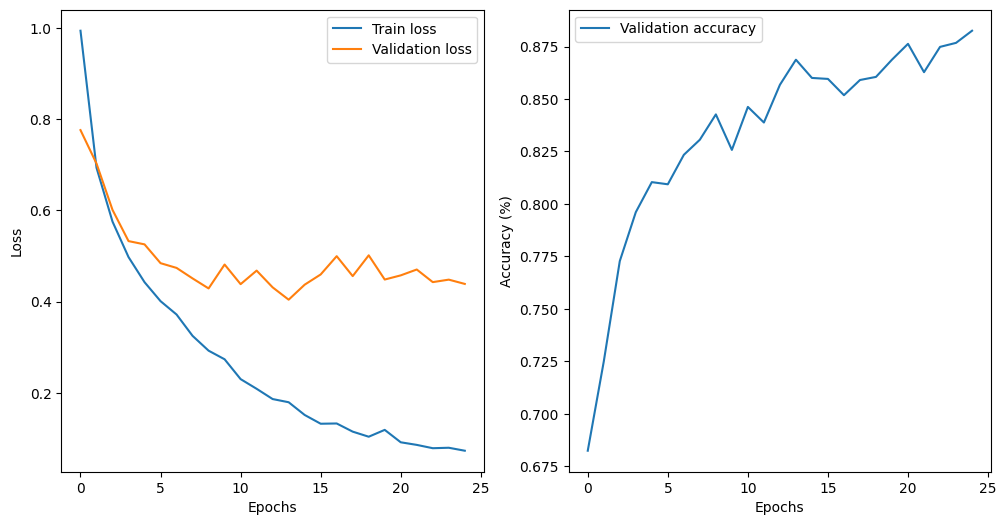

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(train_loss_list, label='Train loss')
ax1.plot(val_loss_list, label='Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(val_acc_list, label='Validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.show()

## Results and Discussion
As demonstrated in the preceding sections, the trained model exhibited commendable performance, achieving an accuracy of approximately 90% on the test dataset after 25 epochs. The learning curve visually depicts the model's progression over training iterations.

Upon closer examination of the training process, a noteworthy observation is the onset of overfitting after approximately 10 epochs. Overfitting occurs when a model learns the training data too well, capturing noise and idiosyncrasies that do not generalize to new, unseen data. This phenomenon is reflected in the divergence of the training and validation accuracy curves.

While the achieved accuracy is commendable, there are always considerations for further improvement. Adjusting the complexity of the model architecture, such as working with ResNet152 or different networks (like DenseNet or EfficientNet), would be worth trying. Also, ballancing the classes surely would have helped our model.

Experimenting with different learning rates, batch sizes, and other hyperparameters to find configurations that contribute to better generalization would also be advised.

In [13]:
val_acc = 0.0
preds_all = []
labels_all = []
model.eval()
with torch.inference_mode():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        y_val_pred = model(images)
        val_acc += accuracy_score(labels.cpu(), y_val_pred.argmax(dim=1).cpu())

        labels_all.extend(labels.cpu())
        preds_all.extend(y_val_pred.argmax(dim=1).cpu())
    val_acc /= len(val_loader)

preds_all = np.array(preds_all)
labels_all = np.array(labels_all)

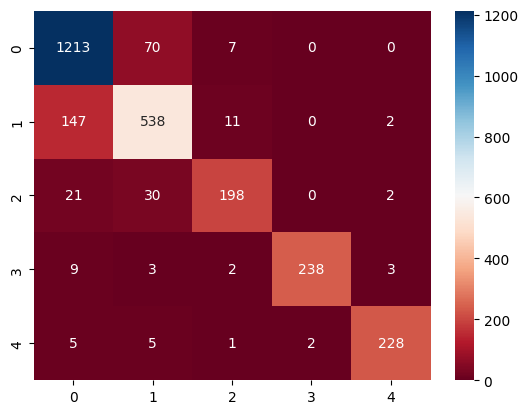

In [14]:
cmatrix = confusion_matrix(labels_all, preds_all)
classes = [0, 1, 2, 3, 4]
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=classes, yticklabels=classes)
plt.show()

It is possible to see that the most difficult class to guess is H1, frequently mislabeled for H0 or H2. On the plots above, the similarity between those three classes can justify their worst scores.

In [15]:
print(classification_report(labels_all, preds_all))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1290
           1       0.83      0.77      0.80       698
           2       0.90      0.79      0.84       251
           3       0.99      0.93      0.96       255
           4       0.97      0.95      0.96       241

    accuracy                           0.88      2735
   macro avg       0.91      0.88      0.89      2735
weighted avg       0.88      0.88      0.88      2735



## Conclusion
In the realm of fungi classification, the project has provided valuable insights into the capabilities of deep learning models, particularly ResNet101. This computer vision project, focused on fungi classification using the ResNet101 architecture, has yielded notable outcomes. The observed accuracy aligns with or surpasses benchmarks set by comparable models in the field.

The primary objective of this project was to have an opportunity to immerse oneself in the world of PyTorch, deepen understanding of neural network architectures, and gain practical insights into training models for image classification. Special acknowledgment goes to the PyTorch community for fostering an environment conducive to learning and experimentation.

The journey does not conclude here; rather, it sets the stage for continuous exploration and refinement in the pursuit of even greater accuracy and understanding in fungi classification.

## References
Here are some links that helped us through our overall implementation. It is also worth mentioning some chats with ChatGPT and random StackOverflow formums.

https://d2l.ai/chapter_computer-vision/fine-tuning.html

https://pytorch.org/vision/stable/index.html

https://stackoverflow.com/questions/75010445/pytorch-apply-different-transform-to-dataset-after-creation